# Sentiment Classification using RNN

## Understanding RNN Architecture and the Vanishing Gradient Problem

This notebook demonstrates:
1. **What are RNNs and where are they used?**
2. **Building RNN for Sentiment Classification**
3. **The Vanishing Gradient Problem in RNNs**
4. **Solutions: LSTM and GRU**
5. **Performance Comparison**

## 1. Introduction to RNN

### What is a Recurrent Neural Network (RNN)?

RNNs are neural networks designed to work with **sequential data** where the order matters:
- Text (word sequences)
- Time series data
- Speech/Audio
- Video frames

**Key Feature**: RNNs have a "memory" - they maintain hidden states that capture information from previous time steps.

### Where are RNNs Used?

1. **Sentiment Analysis** - Classify text as positive/negative
2. **Language Translation** - Translate text from one language to another
3. **Text Generation** - Generate new text (GPT models)
4. **Speech Recognition** - Convert speech to text
5. **Time Series Forecasting** - Stock prices, weather prediction
6. **Video Analysis** - Action recognition in videos

## 2. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, Bidirectional
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb

# Utilities
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Libraries imported successfully!")

d:\Users data\Documents\AI Engnieeering Projects\Deep Learning Demo\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow version: 2.20.0
Libraries imported successfully!


## 3. Load IMDB Movie Reviews Dataset

The IMDB dataset contains 50,000 movie reviews labeled as positive (1) or negative (0).

In [2]:
# Load IMDB dataset
# We'll use top 10,000 most frequent words
vocab_size = 10000
max_length = 200  # Maximum review length

print("Loading IMDB dataset...")
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

print(f"\nDataset loaded successfully!")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"\nClass distribution:")
print(f"Training - Positive: {np.sum(y_train)}, Negative: {len(y_train) - np.sum(y_train)}")
print(f"Test - Positive: {np.sum(y_test)}, Negative: {len(y_test) - np.sum(y_test)}")

Loading IMDB dataset...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

Dataset loaded successfully!
Training samples: 25000
Test samples: 25000

Class distribution:
Training - Positive: 12500, Negative: 12500
Test - Positive: 12500, Negative: 12500


In [3]:
# Examine a sample review
print("\nSample review (encoded):")
print(f"Length: {len(X_train[0])} words")
print(f"First 20 words: {X_train[0][:20]}")
print(f"Label: {'Positive' if y_train[0] == 1 else 'Negative'}")

# Decode the review to see actual text
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

def decode_review(encoded_review):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])

print("\nDecoded review:")
print(decode_review(X_train[0])[:500] + "...")


Sample review (encoded):
Length: 218 words
First 20 words: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]
Label: Positive
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Decoded review:
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to ever...


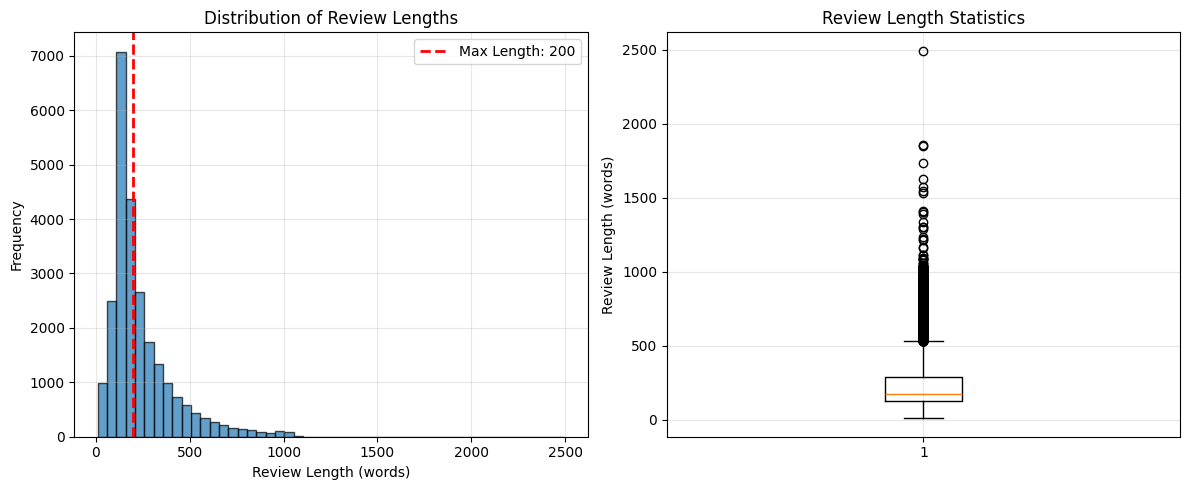


Review Length Statistics:
Mean: 238.71 words
Median: 178.00 words
Max: 2494 words
Min: 11 words


In [4]:
# Visualize review lengths
review_lengths = [len(review) for review in X_train]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(review_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=max_length, color='red', linestyle='--', linewidth=2, label=f'Max Length: {max_length}')
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(review_lengths, vert=True)
plt.ylabel('Review Length (words)')
plt.title('Review Length Statistics')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nReview Length Statistics:")
print(f"Mean: {np.mean(review_lengths):.2f} words")
print(f"Median: {np.median(review_lengths):.2f} words")
print(f"Max: {np.max(review_lengths)} words")
print(f"Min: {np.min(review_lengths)} words")

## 4. Data Preprocessing

Pad sequences to ensure all reviews have the same length.

In [22]:
# Pad sequences to fixed length
# pad_sequences: Makes all sequences the same length by:
#   - Adding zeros at the END (padding='post') if sequence is too short
#   - Cutting from the END (truncating='post') if sequence is too long
#   Example: [1, 2, 3] with maxlen=5 becomes [1, 2, 3, 0, 0]

X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

print("Data after padding:")
print(f"Training data shape: {X_train_padded.shape}")
print(f"Test data shape: {X_test_padded.shape}")
print(f"\nSample padded review:")
print(X_train_padded[0][:50])
print("\nWhat pad_sequences does:")
print(f"✓ Ensures all reviews have same length ({max_length} words)")
print(f"✓ Shorter reviews: Padded with zeros at the end")
print(f"✓ Longer reviews: Truncated (cut) at the end")
print(f"✓ Why needed? Neural networks require fixed input size!")

Data after padding:
Training data shape: (25000, 200)
Test data shape: (25000, 200)

Sample padded review:
[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447]

What pad_sequences does:
✓ Ensures all reviews have same length (200 words)
✓ Shorter reviews: Padded with zeros at the end
✓ Longer reviews: Truncated (cut) at the end
✓ Why needed? Neural networks require fixed input size!


## 5. Build Simple RNN Model

### How RNN Works:

**RNN Cell at time step t:**
```
h_t = tanh(W_hh * h_{t-1} + W_xh * x_t + b_h)
y_t = W_hy * h_t + b_y
```

Where:
- `h_t` = hidden state at time t
- `x_t` = input at time t
- `W` = weight matrices
- `b` = biases

In [23]:
# Build Simple RNN model
embedding_dim = 128
rnn_units = 64

simple_rnn_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length, name='embedding'),
    SimpleRNN(rnn_units, return_sequences=False, name='simple_rnn'),
    Dense(1, activation='sigmoid', name='output')
], name='Simple_RNN')

simple_rnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Build the model by passing sample data shape
simple_rnn_model.build(input_shape=(None, max_length))

print("Simple RNN Model Architecture:")
print("="*70)
simple_rnn_model.summary()
print("="*70)

Simple RNN Model Architecture:


Model: "Simple_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,292,417 (4.93 MB)

 Trainable params: 1,292,417 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train Simple RNN
print("\nTraining Simple RNN...\n")

rnn_history = simple_rnn_model.fit(
    X_train_padded, y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.2,
    verbose=1
)

print("\nSimple RNN training completed!")


Training Simple RNN...

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.5016 - loss: 0.6952 - val_accuracy: 0.5098 - val_loss: 0.6937
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.6428 - loss: 0.6154 - val_accuracy: 0.5046 - val_loss: 0.7394
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.6986 - loss: 0.5179 - val_accuracy: 0.5070 - val_loss: 0.7635
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.7174 - loss: 0.4524 - val_accuracy: 0.4980 - val_loss: 0.8778
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7376 - loss: 0.4042 - val_accuracy: 0.5014 - val_loss: 0.9500

Simple RNN training completed!


In [8]:
# Evaluate Simple RNN
rnn_loss, rnn_accuracy = simple_rnn_model.evaluate(X_test_padded, y_test, verbose=0)

print("\n" + "="*70)
print("SIMPLE RNN - TEST SET EVALUATION")
print("="*70)
print(f"Test Loss: {rnn_loss:.4f}")
print(f"Test Accuracy: {rnn_accuracy:.4f}")
print("="*70)


SIMPLE RNN - TEST SET EVALUATION
Test Loss: 0.9577
Test Accuracy: 0.4982


## 6. The Vanishing Gradient Problem

### What is the Vanishing Gradient Problem?

During backpropagation through time (BPTT), gradients are multiplied at each time step:

```
∂L/∂h_1 = ∂L/∂h_T * ∂h_T/∂h_{T-1} * ... * ∂h_2/∂h_1
```

**Problem**: When sequences are long:
- If gradients < 1, repeated multiplication causes gradients to **vanish** (→ 0)
- If gradients > 1, repeated multiplication causes gradients to **explode** (→ ∞)

**Result**: 
- RNN can't learn long-term dependencies
- Information from early time steps gets lost
- Model performs poorly on sequences requiring long-term memory

In [9]:
# Demonstrate Vanishing Gradient Problem
# Let's train RNNs with different sequence lengths

def train_rnn_with_length(seq_length, epochs=3):
    """Train RNN with specific sequence length"""
    # Prepare data
    X_train_seq = pad_sequences(X_train, maxlen=seq_length, padding='post', truncating='post')
    X_test_seq = pad_sequences(X_test, maxlen=seq_length, padding='post', truncating='post')
    
    # Build model
    model = Sequential([
        Embedding(vocab_size, 64, input_length=seq_length),
        SimpleRNN(32, return_sequences=False),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train
    history = model.fit(
        X_train_seq, y_train,
        batch_size=128,
        epochs=epochs,
        validation_split=0.2,
        verbose=0
    )
    
    # Evaluate
    _, accuracy = model.evaluate(X_test_seq, y_test, verbose=0)
    
    return accuracy, history

# Test different sequence lengths
sequence_lengths = [50, 100, 200, 300, 500]
accuracies = []

print("Testing RNN performance with different sequence lengths...")
print("(This demonstrates how performance degrades with longer sequences)\n")

for seq_len in sequence_lengths:
    print(f"Training with sequence length {seq_len}...", end=' ')
    acc, _ = train_rnn_with_length(seq_len, epochs=3)
    accuracies.append(acc)
    print(f"Accuracy: {acc:.4f}")

print("\nDemonstration completed!")

Testing RNN performance with different sequence lengths...
(This demonstrates how performance degrades with longer sequences)

Training with sequence length 50... Accuracy: 0.7415
Training with sequence length 100... Accuracy: 0.7985
Training with sequence length 200... Accuracy: 0.5048
Training with sequence length 300... Accuracy: 0.5012
Training with sequence length 500... Accuracy: 0.5047

Demonstration completed!


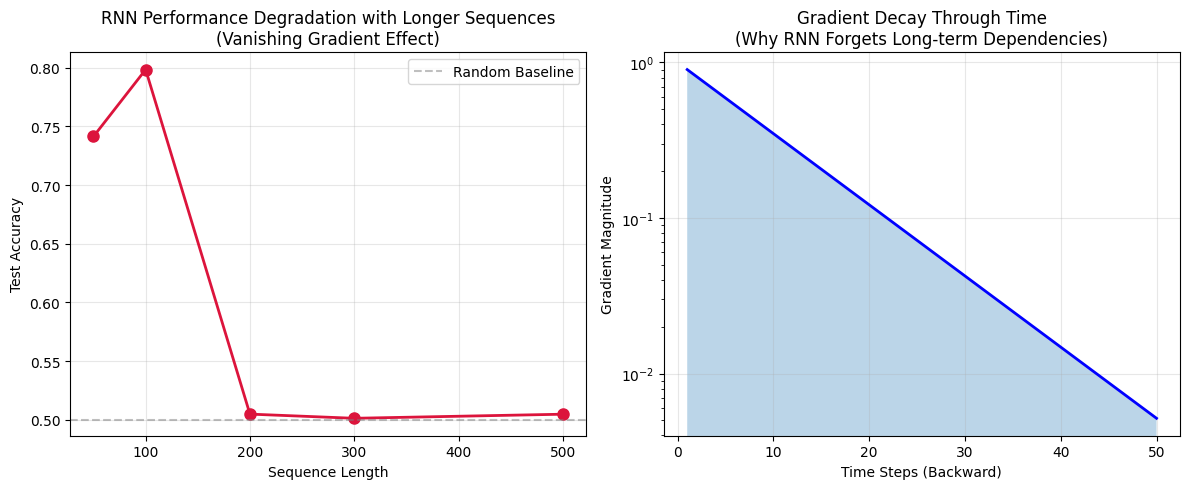


VANISHING GRADIENT PROBLEM DEMONSTRATED:
Shortest sequence (50): 0.7415
Longest sequence (500): 0.5047
Performance drop: 23.68%


In [10]:
# Visualize Vanishing Gradient Effect
plt.figure(figsize=(12, 5))

# Plot 1: Accuracy vs Sequence Length
plt.subplot(1, 2, 1)
plt.plot(sequence_lengths, accuracies, marker='o', linewidth=2, markersize=8, color='crimson')
plt.xlabel('Sequence Length')
plt.ylabel('Test Accuracy')
plt.title('RNN Performance Degradation with Longer Sequences\n(Vanishing Gradient Effect)')
plt.grid(alpha=0.3)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random Baseline')
plt.legend()

# Plot 2: Illustrate Gradient Vanishing
plt.subplot(1, 2, 2)
time_steps = np.arange(1, 51)
gradient_values = 0.9 ** time_steps  # Simulate gradient decay

plt.plot(time_steps, gradient_values, linewidth=2, color='blue')
plt.fill_between(time_steps, 0, gradient_values, alpha=0.3)
plt.xlabel('Time Steps (Backward)')
plt.ylabel('Gradient Magnitude')
plt.title('Gradient Decay Through Time\n(Why RNN Forgets Long-term Dependencies)')
plt.grid(alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("VANISHING GRADIENT PROBLEM DEMONSTRATED:")
print("="*70)
print(f"Shortest sequence ({sequence_lengths[0]}): {accuracies[0]:.4f}")
print(f"Longest sequence ({sequence_lengths[-1]}): {accuracies[-1]:.4f}")
print(f"Performance drop: {(accuracies[0] - accuracies[-1])*100:.2f}%")
print("="*70)

## 7. Solutions to Vanishing Gradient Problem

### LSTM (Long Short-Term Memory)

LSTM introduces:
- **Cell State** (c_t): Long-term memory
- **Gates**: Control information flow
  - **Forget Gate**: What to forget from cell state
  - **Input Gate**: What new information to add
  - **Output Gate**: What to output

**Key Advantage**: Gradients can flow through cell state without vanishing!

### GRU (Gated Recurrent Unit)

GRU is a simplified version of LSTM:
- Fewer parameters (faster training)
- Combines forget and input gates into **update gate**
- No separate cell state

**Key Advantage**: Similar performance to LSTM with less complexity!

In [24]:
# Build LSTM Model
lstm_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length, name='embedding'),
    LSTM(rnn_units, return_sequences=False, name='lstm'),
    Dense(1, activation='sigmoid', name='output')
], name='LSTM_Model')

lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Build the model
lstm_model.build(input_shape=(None, max_length))

print("LSTM Model Architecture:")
print("="*70)
lstm_model.summary()
print("="*70)

LSTM Model Architecture:


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train LSTM
print("\nTraining LSTM...\n")

lstm_history = lstm_model.fit(
    X_train_padded, y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.2,
    verbose=1
)

print("\nLSTM training completed!")


Training LSTM...

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - accuracy: 0.5250 - loss: 0.6906 - val_accuracy: 0.5650 - val_loss: 0.6764
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - accuracy: 0.6259 - loss: 0.6508 - val_accuracy: 0.5600 - val_loss: 0.6853
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.6605 - loss: 0.6141 - val_accuracy: 0.6074 - val_loss: 0.6304
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.6877 - loss: 0.5853 - val_accuracy: 0.6392 - val_loss: 0.6432
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 0.7804 - loss: 0.4941 - val_accuracy: 0.7764 - val_loss: 0.5269

LSTM training completed!


In [25]:
# Build GRU Model
gru_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length, name='embedding'),
    GRU(rnn_units, return_sequences=False, name='gru'),
    Dense(1, activation='sigmoid', name='output')
], name='GRU_Model')

gru_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Build the model
gru_model.build(input_shape=(None, max_length))

print("GRU Model Architecture:")
print("="*70)
gru_model.summary()
print("="*70)

GRU Model Architecture:


Model: "GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317,313 (5.03 MB)

 Trainable params: 1,317,313 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train GRU
print("\nTraining GRU...\n")

gru_history = gru_model.fit(
    X_train_padded, y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.2,
    verbose=1
)

print("\nGRU training completed!")


Training GRU...

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - accuracy: 0.5142 - loss: 0.6925 - val_accuracy: 0.5358 - val_loss: 0.6884
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.5921 - loss: 0.6676 - val_accuracy: 0.5380 - val_loss: 0.6906
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - accuracy: 0.7049 - loss: 0.5753 - val_accuracy: 0.7540 - val_loss: 0.5556
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.8074 - loss: 0.4417 - val_accuracy: 0.7490 - val_loss: 0.5305
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.8523 - loss: 0.3563 - val_accuracy: 0.8216 - val_loss: 0.4323

GRU training completed!


## 8. Compare All Models

In [15]:
# Evaluate all models
print("Evaluating all models on test set...\n")

# Simple RNN
rnn_loss, rnn_acc = simple_rnn_model.evaluate(X_test_padded, y_test, verbose=0)

# LSTM
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_padded, y_test, verbose=0)

# GRU
gru_loss, gru_acc = gru_model.evaluate(X_test_padded, y_test, verbose=0)

# Display results
print("\n" + "="*70)
print("MODEL COMPARISON - TEST SET PERFORMANCE")
print("="*70)
print(f"{'Model':<20} {'Test Loss':<15} {'Test Accuracy':<15}")
print("-"*70)
print(f"{'Simple RNN':<20} {rnn_loss:<15.4f} {rnn_acc:<15.4f}")
print(f"{'LSTM':<20} {lstm_loss:<15.4f} {lstm_acc:<15.4f}")
print(f"{'GRU':<20} {gru_loss:<15.4f} {gru_acc:<15.4f}")
print("="*70)

# Calculate improvements
lstm_improvement = (lstm_acc - rnn_acc) * 100
gru_improvement = (gru_acc - rnn_acc) * 100

print(f"\nLSTM improvement over Simple RNN: {lstm_improvement:+.2f}%")
print(f"GRU improvement over Simple RNN: {gru_improvement:+.2f}%")

Evaluating all models on test set...


MODEL COMPARISON - TEST SET PERFORMANCE
Model                Test Loss       Test Accuracy  
----------------------------------------------------------------------
Simple RNN           0.9577          0.4982         
LSTM                 0.5375          0.7698         
GRU                  0.4275          0.8187         

LSTM improvement over Simple RNN: +27.16%
GRU improvement over Simple RNN: +32.06%


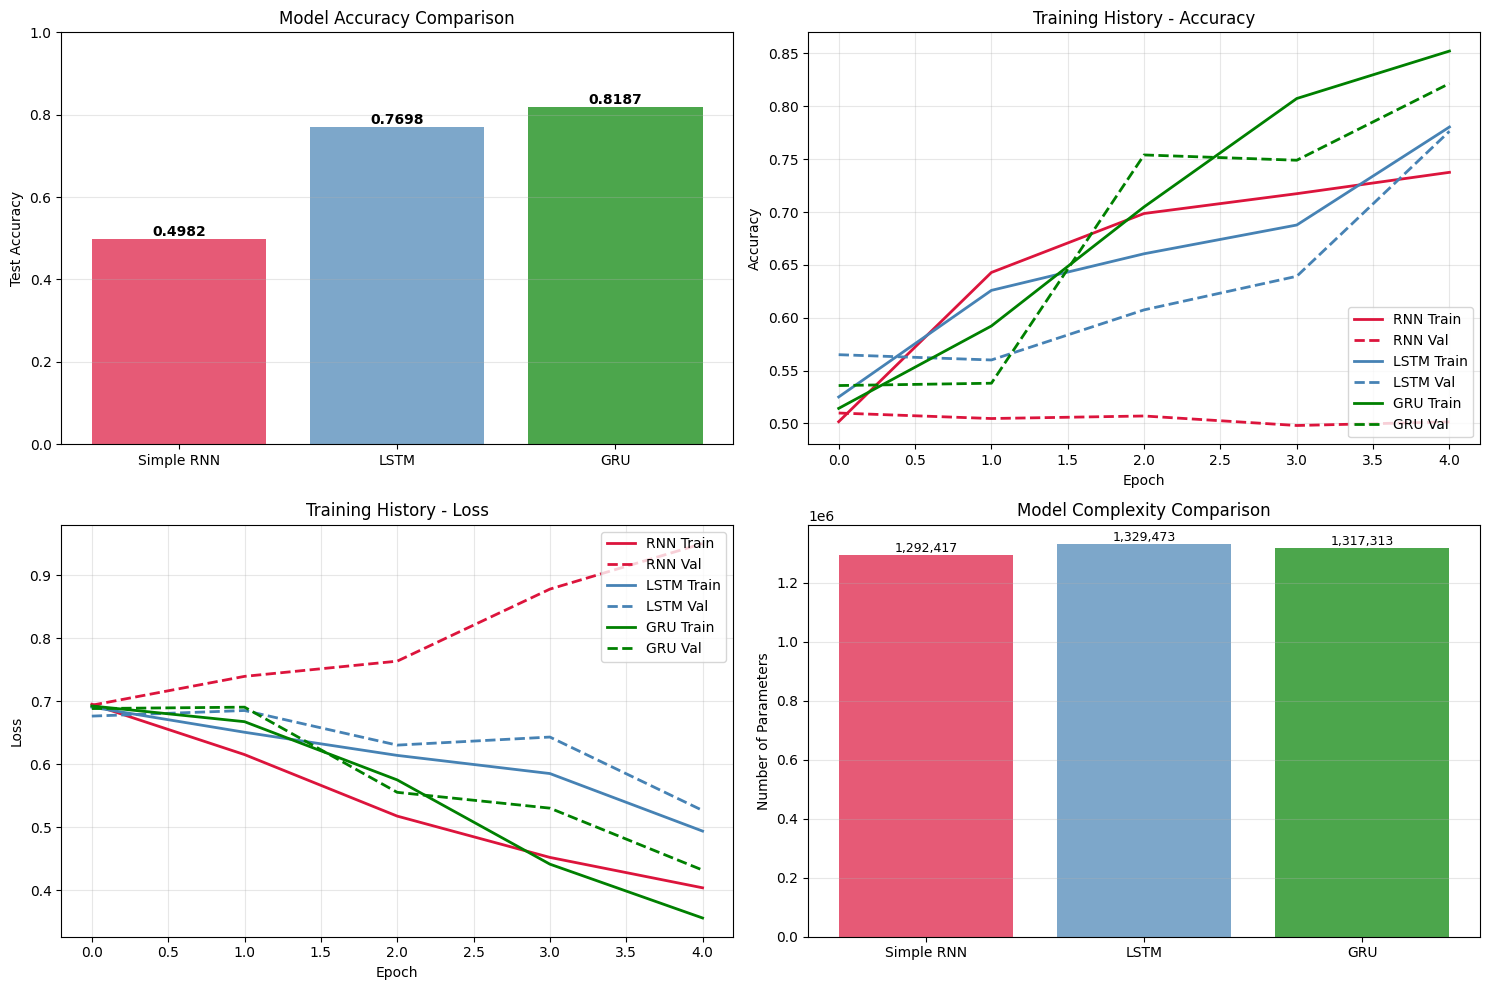

In [16]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Test Accuracy Comparison
ax1 = axes[0, 0]
models = ['Simple RNN', 'LSTM', 'GRU']
accuracies_compare = [rnn_acc, lstm_acc, gru_acc]
colors = ['crimson', 'steelblue', 'green']

bars = ax1.bar(models, accuracies_compare, color=colors, alpha=0.7)
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies_compare):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Training History - Accuracy
ax2 = axes[0, 1]
ax2.plot(rnn_history.history['accuracy'], label='RNN Train', linewidth=2, color='crimson', linestyle='-')
ax2.plot(rnn_history.history['val_accuracy'], label='RNN Val', linewidth=2, color='crimson', linestyle='--')
ax2.plot(lstm_history.history['accuracy'], label='LSTM Train', linewidth=2, color='steelblue', linestyle='-')
ax2.plot(lstm_history.history['val_accuracy'], label='LSTM Val', linewidth=2, color='steelblue', linestyle='--')
ax2.plot(gru_history.history['accuracy'], label='GRU Train', linewidth=2, color='green', linestyle='-')
ax2.plot(gru_history.history['val_accuracy'], label='GRU Val', linewidth=2, color='green', linestyle='--')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training History - Accuracy')
ax2.legend(loc='lower right')
ax2.grid(alpha=0.3)

# Plot 3: Training History - Loss
ax3 = axes[1, 0]
ax3.plot(rnn_history.history['loss'], label='RNN Train', linewidth=2, color='crimson', linestyle='-')
ax3.plot(rnn_history.history['val_loss'], label='RNN Val', linewidth=2, color='crimson', linestyle='--')
ax3.plot(lstm_history.history['loss'], label='LSTM Train', linewidth=2, color='steelblue', linestyle='-')
ax3.plot(lstm_history.history['val_loss'], label='LSTM Val', linewidth=2, color='steelblue', linestyle='--')
ax3.plot(gru_history.history['loss'], label='GRU Train', linewidth=2, color='green', linestyle='-')
ax3.plot(gru_history.history['val_loss'], label='GRU Val', linewidth=2, color='green', linestyle='--')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.set_title('Training History - Loss')
ax3.legend(loc='upper right')
ax3.grid(alpha=0.3)

# Plot 4: Model Parameters Comparison
ax4 = axes[1, 1]
params = [
    simple_rnn_model.count_params(),
    lstm_model.count_params(),
    gru_model.count_params()
]
bars = ax4.bar(models, params, color=colors, alpha=0.7)
ax4.set_ylabel('Number of Parameters')
ax4.set_title('Model Complexity Comparison')
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bar, param in zip(bars, params):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{param:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 9. Test Models on Sample Reviews

In [19]:
# Test on sample reviews
sample_indices = [10, 25, 100, 200]

print("Testing models on sample reviews:")
print("="*90)

for idx in sample_indices:
    # Get the review
    review = X_test_padded[idx:idx+1]
    true_label = y_test[idx]
    
    # Get predictions
    rnn_pred = simple_rnn_model.predict(review, verbose=0)[0][0]
    lstm_pred = lstm_model.predict(review, verbose=0)[0][0]
    gru_pred = gru_model.predict(review, verbose=0)[0][0]
    
    # Decode review
    decoded = decode_review(X_test[idx])
    
    print(f"\nReview #{idx}:")
    print(f"Text: {decoded[:150]}...")
    print(f"True Label: {'Positive' if true_label == 1 else 'Negative'}")
    print(f"Simple RNN: {rnn_pred:.4f} ({'Positive' if rnn_pred > 0.5 else 'Negative'})")
    print(f"LSTM:       {lstm_pred:.4f} ({'Positive' if lstm_pred > 0.5 else 'Negative'})")
    print(f"GRU:        {gru_pred:.4f} ({'Positive' if gru_pred > 0.5 else 'Negative'})")
    print("-"*90)

Testing models on sample reviews:

Review #10:
Text: ? inspired by hitchcock's strangers on a train concept of two men ? murders in exchange for getting rid of the two people messing up their lives throw...
True Label: Positive
Simple RNN: 0.9856 (Positive)
LSTM:       0.7785 (Positive)
GRU:        0.9578 (Positive)
------------------------------------------------------------------------------------------

Review #25:
Text: ? i'm not sure why this film is ? so low on imdb when it's absolutely everything you could ever want in a horror film this is the definition of being ...
True Label: Positive
Simple RNN: 0.5730 (Positive)
LSTM:       0.9117 (Positive)
GRU:        0.9555 (Positive)
------------------------------------------------------------------------------------------

Review #100:
Text: ? a quick glance at the premise of this film would seem to indicate just another dumb ? ? ? slash fest the type where sex equals death and the actors ...
True Label: Positive
Simple RNN: 0.4689 (N

## 10. Key Findings and Summary

In [20]:
print("\n" + "="*80)
print("KEY FINDINGS: RNN vs LSTM vs GRU")
print("="*80)

print("\n1. WHAT ARE RNNs?")
print("   - Neural networks designed for sequential data")
print("   - Process inputs one step at a time, maintaining 'memory'")
print("   - Used in: Text, Speech, Time Series, Video")

print("\n2. WHERE ARE RNNs USED?")
print("   ✓ Sentiment Analysis (this notebook)")
print("   ✓ Machine Translation")
print("   ✓ Speech Recognition")
print("   ✓ Text Generation")
print("   ✓ Time Series Forecasting")
print("   ✓ Video Captioning")

print("\n3. THE VANISHING GRADIENT PROBLEM:")
print("   ✗ Gradients decay exponentially through time steps")
print("   ✗ RNN can't learn long-term dependencies")
print("   ✗ Performance degrades with longer sequences")
print(f"   ✗ Observed: {(accuracies[0] - accuracies[-1])*100:.1f}% accuracy drop")
print(f"     (from {sequence_lengths[0]} to {sequence_lengths[-1]} sequence length)")

print("\n4. SOLUTIONS:")
print("   ✓ LSTM: Gated architecture with cell state")
print(f"     - Test Accuracy: {lstm_acc:.4f} ({lstm_improvement:+.2f}% vs RNN)")
print(f"     - Parameters: {lstm_model.count_params():,}")
print("   ✓ GRU: Simplified LSTM with fewer parameters")
print(f"     - Test Accuracy: {gru_acc:.4f} ({gru_improvement:+.2f}% vs RNN)")
print(f"     - Parameters: {gru_model.count_params():,}")

print("\n5. RECOMMENDATIONS:")
best_model = max([('Simple RNN', rnn_acc), ('LSTM', lstm_acc), ('GRU', gru_acc)], key=lambda x: x[1])
print(f"   ✓ Best Model: {best_model[0]} ({best_model[1]:.4f} accuracy)")
print("   ✓ Use LSTM/GRU for sequences with long-term dependencies")
print("   ✓ GRU is faster to train with similar performance to LSTM")
print("   ✓ Simple RNN works for short sequences but fails on long ones")

print("\n" + "="*80)


KEY FINDINGS: RNN vs LSTM vs GRU

1. WHAT ARE RNNs?
   - Neural networks designed for sequential data
   - Process inputs one step at a time, maintaining 'memory'
   - Used in: Text, Speech, Time Series, Video

2. WHERE ARE RNNs USED?
   ✓ Sentiment Analysis (this notebook)
   ✓ Machine Translation
   ✓ Speech Recognition
   ✓ Text Generation
   ✓ Time Series Forecasting
   ✓ Video Captioning

3. THE VANISHING GRADIENT PROBLEM:
   ✗ Gradients decay exponentially through time steps
   ✗ RNN can't learn long-term dependencies
   ✗ Performance degrades with longer sequences
   ✗ Observed: 23.7% accuracy drop
     (from 50 to 500 sequence length)

4. SOLUTIONS:
   ✓ LSTM: Gated architecture with cell state
     - Test Accuracy: 0.7698 (+27.16% vs RNN)
     - Parameters: 1,329,473
   ✓ GRU: Simplified LSTM with fewer parameters
     - Test Accuracy: 0.8187 (+32.06% vs RNN)
     - Parameters: 1,317,313

5. RECOMMENDATIONS:
   ✓ Best Model: GRU (0.8187 accuracy)
   ✓ Use LSTM/GRU for sequenc